In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rasterio import features
import rasterio
from rasterio.transform import from_origin
import numpy as np

folder_directory = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/all_leks"
# Load the CSV of points
csv_file = f"{folder_directory}/leks_coords.csv"  # Path to your CSV file
buffer_distance = 2000  # Buffer distance in the same unit as coordinates
output_raster = f"{folder_directory}/buffered_leks.tif"  # Path to the output raster file
pixel_size = 100  # Pixel size of the raster

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file)

# Ensure your CSV has columns 'easting' and 'northing'
assert 'easting' in df.columns and 'northing' in df.columns, "CSV must have 'easting' and 'northing' columns."

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['easting'], df['northing']), crs="EPSG:26913")  # NAD83 UTM Zone 13N

# Buffer the points
gdf['buffered'] = gdf.geometry.buffer(buffer_distance)

# Combine all buffers into one shape
union_buffers = gdf['buffered'].unary_union

# Define raster extent based on the buffered area
minx, miny, maxx, maxy = union_buffers.bounds
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Define transform for the raster
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Rasterize the buffered geometry
shapes = [(union_buffers, 1)]  # List of geometries and their values
raster = features.rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Write the raster to a file
with rasterio.open(
    output_raster,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs="EPSG:26913",  # Ensure CRS matches the points' CRS
    transform=transform
) as dst:
    dst.write(raster, 1)

print(f"Raster saved to {output_raster}")

Raster saved to E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/all_leks/buffered_leks.tif


Processing active cells: 100%|██████████| 498262/498262 [05:52<00:00, 1414.03it/s]


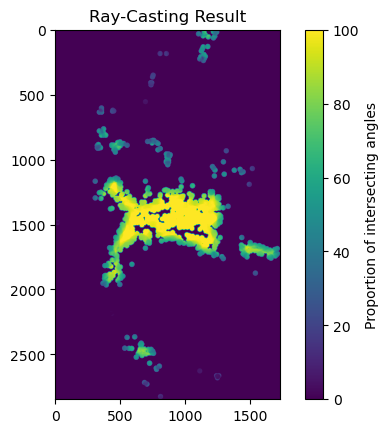

In [7]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def ray_cast_with_progress(raster, min_radius, max_radius, num_angles=360):
    """
    Compute the proportion of angles that intersect active areas for each cell in a raster.
    Includes a progress bar using tqdm.

    Parameters:
        raster (numpy.ndarray): 2D array where active areas are `1` and inactive are `0`.
        min_radius (int): Minimum radius for ray casting (in cells).
        max_radius (int): Maximum radius for ray casting (in cells).
        num_angles (int): Number of angles (rays) to cast per cell.

    Returns:
        numpy.ndarray: A 2D array with the proportion of intersecting angles for each cell.
    """
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)

    # Define angles and ray directions
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)  # Shape: (num_angles, 2)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)  # Shape: (num_angles, num_radii, 2)

    # Find active cells
    active_cells = np.argwhere(raster == 1)

    # Loop through active cells with a progress bar
    for y, x in tqdm(active_cells, desc="Processing active cells"):
        ray_paths = offsets + np.array([y, x])  # Shape: (num_angles, num_radii, 2)
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)

        # Evaluate ray intersections with active areas
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)  # Shape: (num_angles,)
        result[y, x] = np.round(((np.sum(hits) / num_angles) * 100), 0)

    return result

folder_directory = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/all_leks"
# Read the .tif file
input_tif = f"{folder_directory}/buffered_leks.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 48
max_radius = 190
num_angles = 360

# Process the raster
result = ray_cast_with_progress(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = f"{folder_directory}/all_leks_angle_190.tif"
raster_meta.update(dtype="int16", count=1)  # Update metadata for output. Was originally "float32"

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()

Processing active cells: 100%|██████████| 498262/498262 [01:24<00:00, 5875.73it/s]


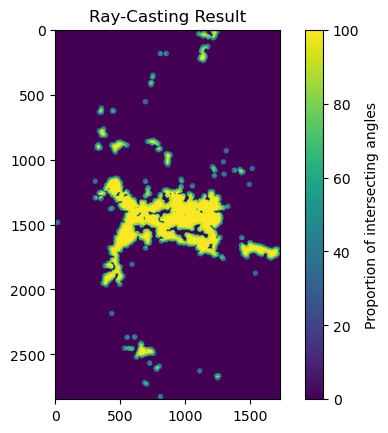

In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def ray_cast_with_progress(raster, min_radius, max_radius, num_angles=360):
    """
    Compute the proportion of angles that intersect active areas for each cell in a raster.
    Includes a progress bar using tqdm.

    Parameters:
        raster (numpy.ndarray): 2D array where active areas are `1` and inactive are `0`.
        min_radius (int): Minimum radius for ray casting (in cells).
        max_radius (int): Maximum radius for ray casting (in cells).
        num_angles (int): Number of angles (rays) to cast per cell.

    Returns:
        numpy.ndarray: A 2D array with the proportion of intersecting angles for each cell.
    """
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)

    # Define angles and ray directions
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)  # Shape: (num_angles, 2)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)  # Shape: (num_angles, num_radii, 2)

    # Find active cells
    active_cells = np.argwhere(raster == 1)

    # Loop through active cells with a progress bar
    for y, x in tqdm(active_cells, desc="Processing active cells"):
        ray_paths = offsets + np.array([y, x])  # Shape: (num_angles, num_radii, 2)
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)

        # Evaluate ray intersections with active areas
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)  # Shape: (num_angles,)
        result[y, x] = np.round(((np.sum(hits) / num_angles) * 100), 0)

    return result

folder_directory = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/all_leks"
# Read the .tif file
input_tif = f"{folder_directory}/buffered_leks.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 21
max_radius = 48
num_angles = 360

# Process the raster
result = ray_cast_with_progress(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = f"{folder_directory}/all_leks_angle_48.tif"
raster_meta.update(dtype="int16", count=1)  # Update metadata for output. Was originally "float32"

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()